In [1]:
# importing libraries
from __future__ import division
import numpy as np#
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")
from scipy import stats
import pandas as pd
import itertools

%load_ext autoreload
%autoreload 2

Auxiliary functions

In [2]:
def intercala_listas(a, b):
    c = list(zip(a, b))
    return [elt for sublist in c for elt in sublist]

def format_names(names):
    names_latex = []
    hi_there = 0
    for n in names:
        if n=='lsig_c':
            hi_there+=1
            if hi_there==2:
                n += '2'
        if n[-1]=='2':
            n = n.replace('2','^x')
        if n[0]=='s':
            n = n.replace('sig',r'$\sigma')
            n += '$'
        elif n[:2]=='ls':
            n = n.replace('lsig',r'$log(\sigma')
            n += ')$'
        elif n[:2]=='ps':
            n = n.replace('psig',r'$\sigma')
            n += '$%'
        elif n[:2]=='pl':
            n = n.replace('plsig',r'$log(\sigma')
            n += ')$%'
        elif n=="mu_y":
            n = n.replace('mu',r'$\mu')
            n += '$'
        else:
            n = n.replace('lpsig',r'$log(\sigma')
            n += '^x)$%'
    #     print n
        names_latex.append(n)
    return names_latex

def format_short(AllTab):
    tab_short = AllTab.iloc[-8:].copy()
    tab_short.rename(index={'lsig_y2': 'log_variance', 
                                   'sig_x': 'spell_number',
                                  'lsig_c': 'constant',
                                   'lsig_e2': 'duration_dependence',
                                   'lsig_b2': 'heterogeneity',
                                   'lpsig_x': 'spell_number_percentage',
                                  'lpsig_x': 'spell_number_percentage',
                                  'lpsig_e': 'duration_dependence_percentage',
                                  'lpsig_b': 'heterogeneity_percentage'},inplace='True')
    tab_short = tab_short.append(pd.Series(1-AllTab.iloc[-3:].sum(),name='constant_percentage'))
    tab_short = tab_short.reindex(['log_variance', 'spell_number', 'constant', 'duration_dependence',
           'heterogeneity', 'constant_percentage','spell_number_percentage',
           'duration_dependence_percentage', 'heterogeneity_percentage'])
    return tab_short

def format_very_short(AllTab):
    tab_short = AllTab.iloc[-3:].copy()
    tab_short = tab_short.T
    tab_short.reset_index(level=0,inplace=True)
    tab_short['shareC'] = 1-AllTab.iloc[-3:].sum().values
    tab_short['var'] = AllTab.iloc[-8].values
    tab_short.rename(columns={'lpsig_x': 'shareS',
                            'lpsig_e': 'shareDD',
                            'lpsig_b': 'shareH',
                             'index':'cat'},inplace='True')
    tab_short = tab_short[['shareC','shareDD','shareH','shareS','cat','var']]
    return tab_short

def format_column_names(column_names):
    var_name = []
    type1 = []
    for name in column_names:
        split = name.split(',')
        n,t = split[0],split[1:]
        var_name.append(n)
        type1.append(t)
    return var_name,type1

## Reading the data
### New version

In [39]:
table_raw = np.empty(23)
names = []
sigmas = []
column_names = []
noobs = []
results_follow = 0
first_row = 1
f = open('results/all_results.log','r')
for line in f:
    words = line.split()
#     print(words)
    if len(words)>1 and words[1]=="******":
        column_names.append("".join(words[2:-1]))
        results_follow=1
    elif results_follow==1 and len(words)==7:
        if first_row==1:
            names.append(words[0])
        sigmas.append(float(words[3]))
        if words[0]=='lpsig_b':
            results_follow=0
            table_raw = np.vstack((table_raw,np.array(sigmas)))
            noobs.append(int(words[2].replace(',',"")))
            sigmas = []
            first_row = 0
#             print(column_names[-1])
#             names_latex = format_names(names)
#             pd.DataFrame(sigmas, index=names_latex, columns=['Raw'])
f.close()

names_latex = format_names(names)
# names_latex = format_names(names)
names_latex = names
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=column_names)
short_tab = format_very_short(AllTab)
short_tab['N'] = np.array(noobs)
# AllTab.round(3).to_csv('results/all_results.csv')
short_tab.round(3).to_stata('results/all_results.dta')

In [47]:
# short_tab_old = short_tab
short_tab84

,shareC,shareDD,shareH,shareS,cat,var,N
0,1.215032,-0.430935,0.205366,0.010536,Raw,1.353819,551794
1,1.008861,-0.254579,0.238886,0.006832,LTU,1.630486,551794
2,0.667371,0.126267,0.204868,0.001494,STU,2.464797,852006
3,0.527299,0.265625,0.201343,0.005732,STU+SpellAdj,3.119545,852006
4,0.509252,0.206012,0.285888,-0.001152,NE(NOSpellAdj),3.230095,1066856
5,0.437372,0.287204,0.270249,0.005175,NE+SpellAdj,3.760946,1066856
6,0.437868,0.293290,0.263214,0.005628,STU+Recalls+SpellAdj,3.756687,1013012


In [49]:
short_tab96

,shareC,shareDD,shareH,shareS,cat,var,N
0,1.290154,-0.507585,0.206385,0.011046,Raw,1.274990,430272
1,1.123429,-0.367165,0.237267,0.006469,LTU,1.464209,430272
2,0.718844,0.091509,0.188791,0.000856,STU,2.288305,689786
3,0.574935,0.237980,0.181656,0.005429,STU+SpellAdj,2.861077,689786
4,0.569676,0.179497,0.251410,-0.000583,NE(NOSpellAdj),2.887488,869048
5,0.494674,0.262172,0.238944,0.004210,NE+SpellAdj,3.325288,869048
6,0.496806,0.270841,0.227800,0.004552,STU+Recalls+SpellAdj,3.311016,822214


In [40]:
short_tab

,shareC,shareDD,shareH,shareS,cat,var,N
0,1.184699,-0.407468,0.212557,0.010212,Raw,1.388483,583378
1,0.982160,-0.233017,0.244355,0.006502,LTU,1.674813,583378
2,0.637702,0.151502,0.209657,0.001138,STU,2.579470,924208
3,0.505203,0.278588,0.210961,0.005249,STU+SpellAdj,3.255989,924208
4,0.499336,0.227252,0.275013,-0.001601,NE(NOSpellAdj),3.294243,1155700
5,0.425915,0.300700,0.267800,0.005585,NE+SpellAdj,3.862121,1155700
6,0.427495,0.305841,0.260705,0.005959,STU+Recalls+SpellAdj,3.847846,1095058


In [42]:
short_tab_noA

,shareC,shareDD,shareH,shareS,cat,var,N
0,1.184699,-0.407468,0.212557,0.010212,Raw,1.388483,583378
1,0.982160,-0.233017,0.244355,0.006502,LTU,1.674813,583378
2,0.647948,0.145602,0.205472,0.000978,STU,2.538683,875468
3,0.512057,0.281527,0.201462,0.004954,STU+SpellAdj,3.212404,875468
4,0.501791,0.228445,0.271267,-0.001503,NE(NOSpellAdj),3.278130,1120108
5,0.432196,0.308477,0.254194,0.005133,NE+SpellAdj,3.805994,1120108
6,0.433513,0.312480,0.248614,0.005393,STU+Recalls+SpellAdj,3.794429,1054238


In [46]:
table_raw = np.empty(23)
names = []
sigmas = []
column_names = []
noobs = []
results_follow = 0
first_row = 1
f = open('results/all_results84.log','r')
for line in f:
    words = line.split()
#     print(words)
    if len(words)>1 and words[1]=="******":
        column_names.append("".join(words[2:-1]))
        results_follow=1
    elif results_follow==1 and len(words)==7:
        if first_row==1:
            names.append(words[0])
        sigmas.append(float(words[3]))
        if words[0]=='lpsig_b':
            results_follow=0
            table_raw = np.vstack((table_raw,np.array(sigmas)))
            noobs.append(int(words[2].replace(',',"")))
            sigmas = []
            first_row = 0
#             print(column_names[-1])
#             names_latex = format_names(names)
#             pd.DataFrame(sigmas, index=names_latex, columns=['Raw'])
f.close()

names_latex = format_names(names)
# names_latex = format_names(names)
names_latex = names
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=column_names)
short_tab84= format_very_short(AllTab)
short_tab84['N'] = np.array(noobs)
# AllTab.round(3).to_csv('results/all_results.csv')
short_tab84.round(3).to_stata('results/all_results84.dta')

In [48]:
table_raw = np.empty(23)
names = []
sigmas = []
column_names = []
noobs = []
results_follow = 0
first_row = 1
f = open('results/all_results96.log','r')
for line in f:
    words = line.split()
#     print(words)
    if len(words)>1 and words[1]=="******":
        column_names.append("".join(words[2:-1]))
        results_follow=1
    elif results_follow==1 and len(words)==7:
        if first_row==1:
            names.append(words[0])
        sigmas.append(float(words[3]))
        if words[0]=='lpsig_b':
            results_follow=0
            table_raw = np.vstack((table_raw,np.array(sigmas)))
            noobs.append(int(words[2].replace(',',"")))
            sigmas = []
            first_row = 0
#             print(column_names[-1])
#             names_latex = format_names(names)
#             pd.DataFrame(sigmas, index=names_latex, columns=['Raw'])
f.close()

names_latex = format_names(names)
# names_latex = format_names(names)
names_latex = names
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=column_names)
short_tab96= format_very_short(AllTab)
short_tab96['N'] = np.array(noobs)
# AllTab.round(3).to_csv('results/all_results.csv')
short_tab96.round(3).to_stata('results/all_results96.dta')

In [41]:
table_raw = np.empty(23)
names = []
sigmas = []
column_names = []
noobs = []
results_follow = 0
first_row = 1
f = open('results/all_results_noA.log','r')
for line in f:
    words = line.split()
    if len(words)>1 and words[1]=="******":
        column_names.append("".join(words[2:-1]))
        results_follow=1
    elif results_follow==1 and len(words)==7:
        if first_row==1:
            names.append(words[0])
        sigmas.append(float(words[3]))
        if words[0]=='lpsig_b':
            results_follow=0
            table_raw = np.vstack((table_raw,np.array(sigmas)))
            noobs.append(int(words[2].replace(',',"")))
            sigmas = []
            first_row = 0
#             print(column_names[-1])
#             names_latex = format_names(names)
#             pd.DataFrame(sigmas, index=names_latex, columns=['Raw'])
f.close()

names_latex = format_names(names)
# names_latex = format_names(names)
names_latex = names
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=column_names)
short_tab_noA = format_very_short(AllTab)
short_tab_noA['N'] = np.array(noobs)
# AllTab.round(3).to_csv('results/all_results.csv')
short_tab_noA.round(3).to_stata('results/all_results_noA.dta')

In [16]:
table_raw = np.empty(23)
names = []
sigmas = []
column_names = []
results_follow = 0
first_row = 1
f = open('results/BC_all.log','r')
for line in f:
    words = line.split()
    if len(words)>1 and words[1]=="******":
        column_names.append("".join(words[2:-1]))
        results_follow=1
    elif results_follow==1 and len(words)==7:
        if first_row==1:
            names.append(words[0])
        sigmas.append(float(words[3]))
        if words[0]=='lpsig_b':
            results_follow=0
            table_raw = np.vstack((table_raw,np.array(sigmas)))
            sigmas = []
            first_row = 0
#             print(column_names[-1])
#             names_latex = format_names(names)
#             pd.DataFrame(sigmas, index=names_latex, columns=['Raw'])
f.close()

# names_latex = format_names(names)
names_latex = names
var_names, year_names = format_column_names(column_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['period'] = list(itertools.chain.from_iterable(year_names))
short_tab.round(3).to_stata('results/BC_results.dta')

In [64]:
table_raw = np.empty(23)
names = []
sigmas = []
column_names = []
results_follow = 0
first_row = 1
f = open('results/all_results_sex.log','r')
for line in f:
    words = line.split()
    if len(words)>1 and words[1]=="******":
        column_names.append("".join(words[2:-1]))
        results_follow=1
    elif results_follow==1 and len(words)==7:
        if first_row==1:
            names.append(words[0])
        sigmas.append(float(words[3]))
        if words[0]=='lpsig_b':
            results_follow=0
            table_raw = np.vstack((table_raw,np.array(sigmas)))
            sigmas = []
            first_row = 0
#             print(column_names[-1])
#             names_latex = format_names(names)
#             pd.DataFrame(sigmas, index=names_latex, columns=['Raw'])
f.close()

# names_latex = format_names(names)
names_latex = names
var_names, sex_names = format_column_names(column_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['gender'] = list(itertools.chain.from_iterable(sex_names))
short_tab.round(3).to_stata('results/results_sex.dta')

In [71]:
table_raw = np.empty(23)
names = []
sigmas = []
column_names = []
results_follow = 0
first_row = 1
f = open('results/all_results_educ.log','r')
for line in f:
    words = line.split()
    if len(words)>1 and words[1]=="******":
        column_names.append("".join(words[2:-1]))
        results_follow=1
    elif results_follow==1 and len(words)==7:
        if first_row==1:
            names.append(words[0])
        sigmas.append(float(words[3]))
        if words[0]=='lpsig_b':
            results_follow=0
            table_raw = np.vstack((table_raw,np.array(sigmas)))
            sigmas = []
            first_row = 0
#             print(column_names[-1])
#             names_latex = format_names(names)
#             pd.DataFrame(sigmas, index=names_latex, columns=['Raw'])
f.close()

# names_latex = format_names(names)
names_latex = names
var_names, educ_names = format_column_names(column_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['educ'] = list(itertools.chain.from_iterable(educ_names))
short_tab.round(3).to_stata('results/results_educ.dta')

In [72]:
table_raw = np.empty(23)
names = []
sigmas = []
column_names = []
results_follow = 0
first_row = 1
f = open('results/BC_educ.log','r')
for line in f:
    words = line.split()
    if len(words)>1 and words[1]=="******":
        column_names.append("".join(words[2:-1]))
        results_follow=1
    elif results_follow==1 and len(words)==7:
        if first_row==1:
            names.append(words[0])
        sigmas.append(float(words[3]))
        if words[0]=='lpsig_b':
            results_follow=0
            table_raw = np.vstack((table_raw,np.array(sigmas)))
            sigmas = []
            first_row = 0
#             print(column_names[-1])
#             names_latex = format_names(names)
#             pd.DataFrame(sigmas, index=names_latex, columns=['Raw'])
f.close()

# names_latex = format_names(names)
names_latex = names
var_names, educ_names = format_column_names(column_names)
data_names = np.array(educ_names)
AllTab = pd.DataFrame(table_raw[1:,:].T, index=names_latex, columns=var_names)
short_tab = format_very_short(AllTab)
short_tab['educ'] = data_names[:,1]
short_tab['period'] = data_names[:,0]
short_tab.round(3).to_stata('results/results_BC_educ.dta')
# short_tab.round(3).to_csv('results/results_BC_educ.csv')
# short_tab

## Descriptive stats

In [62]:
table_raw = np.zeros((5,11,7))
var_names = []
row_n = 0
table_n = 0
column_names = []
results_follow = 0
names_done = 0
f = open('results/descriptive_stats_part2.log','r')
for line in f:
    words = line.split()
    if len(words)>1 and words[0] == "Variable":
        results_follow=1
        if names_done == 0:
            stats_names = words[2:]       
    elif len(words)>1 and results_follow==1:
        if words[0]!='before92':
            if names_done ==0:
                column_names.append(words[0])
            idx = 0
            for w in words[2:]: 
                w = w.replace(",","")
                table_raw[idx,row_n,table_n] = np.array(w)
                idx+=1
            row_n += 1

        elif words[0]=='before92':
            if names_done ==0:
                column_names.append(words[0])
                names_done = 1 
            idx=0
            for w in words[2:]: 
                w = w.replace(",","")
                table_raw[idx,row_n,table_n] = np.array(w)
                idx+=1
            results_follow=0
            table_n +=1
            row_n = 0
f.close()

column_names_format =  ['duration','duration_last','age','female','college',
              'year_of_spell','last_T','last_P','last_A','before_84','before_92']
table_names_format = ['Raw', 'LTU', 'STU_noAjd', 'STU','STU_Recalls', 'NE_noAjd', 'NE']

In [63]:
means_table = pd.DataFrame(table_raw[1,:,:].T, columns=column_names_format) #, index=names_latex
means_table['version'] = table_names_format
# means_table.round(3).to_stata('results/descriptive_stats_means.dta')
stds_table = pd.DataFrame(table_raw[2,:,:].T, columns=column_names_format) #, index=names_latex
stds_table['version'] = table_names_format

final_table = pd.concat([means_table, stds_table]).sort_index(kind='merge')
final_table['stat'] = ['mean','std']*7
final_table = final_table[list(final_table.columns[-2:])+list(final_table.columns[:-2])]
final_table.to_stata('results/descriptive_stats.dta')
means_table

,duration,duration_last,age,female,college,year_of_spell,last_T,last_P,last_A,before_84,before_92,version
0,248.2181,453.7352,32.30829,0.413735,0.108958,1998.404,0.682072,0.311945,0.005592,0.112318,0.269028,Raw
1,353.9770,453.7352,32.30829,0.413735,0.108958,1998.404,0.682072,0.311945,0.005592,0.112318,0.269028,LTU
2,386.1211,495.1598,32.13768,0.417592,0.132442,1997.895,0.634614,0.319946,0.043952,0.133043,0.274082,STU_noAjd
3,354.1303,481.6906,30.71043,0.417592,0.132442,1996.467,0.630408,0.306978,0.061842,0.151393,0.305498,STU
4,290.4843,501.4177,30.35788,0.426858,0.140676,1995.792,0.409996,0.536245,0.050294,0.166100,0.327789,STU_Recalls
5,363.1301,539.2480,31.97252,0.426718,0.141452,1997.265,0.423268,0.537649,0.034178,0.149958,0.293736,NE_noAjd
6,295.4518,517.6939,30.18505,0.426718,0.141452,1995.478,0.404219,0.546139,0.045808,0.175789,0.338540,NE


In [61]:
table_raw = np.zeros((5,11,7))
var_names = []
row_n = 0
table_n = 0
column_names = []
results_follow = 0
names_done = 0
f = open('results/descriptive_stats96.log','r')
for line in f:
    words = line.split()
    if len(words)>1 and words[0] == "Variable":
        results_follow=1
        if names_done == 0:
            stats_names = words[2:]       
    elif len(words)>1 and results_follow==1:
        if words[0]!='before92':
            if names_done ==0:
                column_names.append(words[0])
            idx = 0
            for w in words[2:]: 
                w = w.replace(",","")
                table_raw[idx,row_n,table_n] = np.array(w)
                idx+=1
            row_n += 1

        elif words[0]=='before92':
            if names_done ==0:
                column_names.append(words[0])
                names_done = 1 
            idx=0
            for w in words[2:]: 
                w = w.replace(",","")
                table_raw[idx,row_n,table_n] = np.array(w)
                idx+=1
            results_follow=0
            table_n +=1
            row_n = 0
f.close()

column_names_format =  ['duration','duration_last','age','female','college',
              'year_of_spell','last_T','last_P','last_A','before_84','before_92']
table_names_format = ['Raw', 'LTU', 'STU_noAjd', 'STU','STU_Recalls', 'NE_noAjd', 'NE']

means_table96 = pd.DataFrame(table_raw[1,:,:].T, columns=column_names_format) #, index=names_latex
means_table96['version'] = table_names_format
# means_table96.round(3).to_stata('results/descriptive_stats_means.dta')
stds_table96 = pd.DataFrame(table_raw[2,:,:].T, columns=column_names_format) #, index=names_latex
stds_table96['version'] = table_names_format

final_table96 = pd.concat([means_table96, stds_table96]).sort_index(kind='merge')
final_table96['stat'] = ['mean','std']*7
final_table96 = final_table96[list(final_table96.columns[-2:])+list(final_table96.columns[:-2])]
final_table96.to_stata('results/descriptive_stats96.dta')
means_table96

,duration,duration_last,age,female,college,year_of_spell,last_T,last_P,last_A,before_84,before_92,version
0,190.7582,363.0519,33.70517,0.550898,0.123443,2004.283,0.708587,0.284964,0.005903,0.000000,0.000000,Raw
1,245.1106,363.0519,33.70517,0.550898,0.123443,2004.283,0.708587,0.284964,0.005903,0.000000,0.000000,LTU
2,254.9513,386.4403,33.31425,0.547932,0.150467,2004.082,0.656779,0.298585,0.042615,0.000300,0.002766,STU_noAjd
3,224.1607,376.5824,32.14592,0.547932,0.150467,2002.914,0.639830,0.300376,0.058740,0.000352,0.003824,STU
4,181.1696,377.6110,31.85762,0.536345,0.158915,2002.364,0.652266,0.297862,0.047878,0.000574,0.005573,STU_Recalls
5,237.4543,408.9748,33.22313,0.537082,0.159494,2003.680,0.651427,0.310651,0.034013,0.000623,0.005306,NE_noAjd
6,182.1737,392.5240,31.73462,0.537082,0.159494,2002.192,0.644419,0.308775,0.044430,0.000673,0.006565,NE


In [58]:
means_table

,duration,duration_last,age,female,college,year_of_spell,last_T,last_P,last_A,before_84,before_92,version
0,248.2181,453.7352,32.30829,0.413735,0.108958,1998.404,0.682072,0.311945,0.005592,0.112318,0.269028,Raw
1,353.9770,453.7352,32.30829,0.413735,0.108958,1998.404,0.682072,0.311945,0.005592,0.112318,0.269028,LTU
2,386.1211,495.1598,32.13768,0.417592,0.132442,1997.895,0.634614,0.319946,0.043952,0.133043,0.274082,STU_noAjd
3,354.1303,481.6906,30.71043,0.417592,0.132442,1996.467,0.630408,0.306978,0.061842,0.151393,0.305498,STU
4,290.4843,501.4177,30.35788,0.426858,0.140676,1995.792,0.409996,0.536245,0.050294,0.166100,0.327789,STU_Recalls
5,363.1301,539.2480,31.97252,0.426718,0.141452,1997.265,0.423268,0.537649,0.034178,0.149958,0.293736,NE_noAjd
6,295.4518,517.6939,30.18505,0.426718,0.141452,1995.478,0.404219,0.546139,0.045808,0.175789,0.338540,NE


In [60]:
table_raw = np.zeros((5,11,7))
var_names = []
row_n = 0
table_n = 0
column_names = []
results_follow = 0
names_done = 0
f = open('results/descriptive_stats_part2_noA.log','r')
for line in f:
    words = line.split()
    if len(words)>1 and words[0] == "Variable":
        results_follow=1
        if names_done == 0:
            stats_names = words[2:]       
    elif len(words)>1 and results_follow==1:
        if words[0]!='before92':
            if names_done ==0:
                column_names.append(words[0])
            idx = 0
            for w in words[2:]: 
                w = w.replace(",","")
                table_raw[idx,row_n,table_n] = np.array(w)
                idx+=1
            row_n += 1

        elif words[0]=='before92':
            if names_done ==0:
                column_names.append(words[0])
                names_done = 1 
            idx=0
            for w in words[2:]: 
                w = w.replace(",","")
                table_raw[idx,row_n,table_n] = np.array(w)
                idx+=1
            results_follow=0
            table_n +=1
            row_n = 0
f.close()

column_names_format =  ['duration','duration_last','age','female','college',
              'year_of_spell','last_T','last_P','last_A','before_84','before_92']
table_names_format = ['Raw', 'LTU', 'STU_noAjd', 'STU','STU_Recalls', 'NE_noAjd', 'NE']

means_table = pd.DataFrame(table_raw[1,:,:].T, columns=column_names_format) #, index=names_latex
means_table['version'] = table_names_format
# means_table.round(3).to_stata('results/descriptive_stats_means.dta')
stds_table = pd.DataFrame(table_raw[2,:,:].T, columns=column_names_format) #, index=names_latex
stds_table['version'] = table_names_format

final_table = pd.concat([means_table, stds_table]).sort_index(kind='merge')
final_table['stat'] = ['mean','std']*7
final_table = final_table[list(final_table.columns[-2:])+list(final_table.columns[:-2])]
final_table.to_stata('results/descriptive_stats_noA.dta')
means_table

,duration,duration_last,age,female,college,year_of_spell,last_T,last_P,last_A,before_84,before_92,version
0,248.2181,453.7352,32.30829,0.413735,0.108958,1998.404,0.682072,0.311945,0.005592,0.112318,0.269028,Raw
1,353.9770,453.7352,32.30829,0.413735,0.108958,1998.404,0.682072,0.311945,0.005592,0.112318,0.269028,LTU
2,367.9815,446.6976,32.09910,0.418949,0.134447,1998.145,0.664368,0.330106,0.004025,0.128692,0.265565,STU_noAjd
3,332.7510,420.0455,30.74323,0.418949,0.134447,1996.789,0.674260,0.322135,0.002801,0.145562,0.293510,STU
4,269.1980,449.8442,30.39599,0.428328,0.142518,1996.049,0.436188,0.558308,0.002067,0.160894,0.317770,STU_Recalls
5,346.8617,500.6193,31.98611,0.427453,0.143059,1997.472,0.440549,0.551287,0.003250,0.145851,0.286357,NE_noAjd
6,275.1052,469.4527,30.22800,0.427453,0.143059,1995.714,0.427921,0.566460,0.001795,0.170805,0.329301,NE


In [10]:
table_raw = np.zeros((5,11,14))
var_names = []
row_n = 0
table_n = 0
column_names = []
results_follow = 0
names_done = 0
f = open('results/descriptive_stats_part2_BC.log','r')
for line in f:
    words = line.split()
    if len(words)>1 and words[0] == "Variable":
        results_follow=1
        if names_done == 0:
            stats_names = words[2:]       
    elif len(words)>1 and results_follow==1:
        if words[0]!='before92':
            if names_done ==0:
                column_names.append(words[0])
            idx = 0
            for w in words[2:]: 
                w = w.replace(",","")
                table_raw[idx,row_n,table_n] = np.array(w)
                idx+=1
            row_n += 1

        elif words[0]=='before92':
            if names_done ==0:
                column_names.append(words[0])
                names_done = 1 
            idx=0
            for w in words[2:]: 
                w = w.replace(",","")
                table_raw[idx,row_n,table_n] = np.array(w)
                idx+=1
            results_follow=0
            table_n +=1
            row_n = 0
f.close()

column_names_format =  ['duration','duration_last','age','female','college',
              'year_of_spell','last_T','last_P','last_A','before_84','before_92']
table_names_format = ['Raw','LTU', 'STU_noAjd', 'STU','STU_Recalls', 'NE_noAjd', 'NE']*2
year_names = ['2002-2007','2008-2013']*7

In [14]:
means_table = pd.DataFrame(table_raw[1,:,:].T, columns=column_names_format) #, index=names_latex
means_table['version'] = table_names_format
means_table['period'] = year_names
means_table.round(3).to_stata('results/descriptive_stats_means_BC.dta')
stds_table = pd.DataFrame(table_raw[2,:,:].T, columns=column_names_format) #, index=names_latex
stds_table['version'] = table_names_format
stds_table['period'] = year_names

final_table_BC = pd.concat([means_table, stds_table]).sort_index(kind='merge')
final_table_BC['stat'] = ['mean','std']*14
final_table_BC = final_table_BC[list(final_table_BC.columns[-3:])+list(final_table_BC.columns[:-3])]
final_table_BC.to_stata('results/descriptive_stats_BC.dta')
final_table_BC

,version,period,stat,duration,duration_last,age,female,college,year_of_spell,last_T,last_P,last_A,before_84,before_92
0,Raw,2002-2007,mean,148.5305,268.9980,34.935820,0.521487,0.114436,2003.646000,0.789258,0.205413,0.004636,0.000007,0.000070
0,Raw,2002-2007,std,207.7290,525.0438,6.939536,0.499540,0.318342,1.762118,0.407837,0.404005,0.067930,0.002644,0.008362
1,LTU,2008-2013,mean,183.3212,268.9980,34.935820,0.521487,0.114436,2003.646000,0.789258,0.205413,0.004636,0.000007,0.000070
1,LTU,2008-2013,std,269.8854,525.0438,6.939536,0.499540,0.318342,1.762118,0.407837,0.404005,0.067930,0.002644,0.008362
2,STU_noAjd,2002-2007,mean,178.8111,279.7800,33.707420,0.544412,0.141846,2003.728000,0.729634,0.231750,0.037422,0.000076,0.000963
2,STU_noAjd,2002-2007,std,301.6022,537.1427,6.977566,0.498024,0.348893,1.993098,0.444149,0.421951,0.189794,0.008718,0.031014
3,STU,2008-2013,mean,164.8980,281.9175,33.413080,0.544412,0.141846,2003.434000,0.719987,0.237698,0.041447,0.000079,0.001102
3,STU,2008-2013,std,294.9889,547.7923,6.954995,0.498024,0.348893,1.960599,0.449006,0.425674,0.199323,0.008898,0.033180
4,STU_Recalls,2002-2007,mean,134.8501,288.8107,33.305570,0.526884,0.151427,2003.182000,0.739332,0.226619,0.032480,0.000164,0.001617
4,STU_Recalls,2002-2007,std,263.3684,558.8882,7.047809,0.499277,0.358465,2.048316,0.438999,0.418645,0.177272,0.012802,0.040183


### Old version

In [14]:
table_raw = np.zeros(22).astype(int)
names = []
sigmas = []
f = open('results/table_lowest.log','r')
for line in f:
    words = line.split()    
#     print(words)
    if len(words)==7:
        names.append(words[0])
        sigmas.append(float(words[3]))
f.close()

names_latex = format_names(names)

AllTab = pd.DataFrame(sigmas, index=names_latex, columns=['Raw'])

In [14]:
for ffile,name in zip(['results/table_lower.log','results/table_ne.log','results/table_lower_plus.log',
                       'results/table_upper.log'],['LTU','NE','STU','Spell Sel.']):
    table_raw = np.zeros(22).astype(int)
    sigmas = []
    f = open(ffile,'r')
    for line in f:
        words = line.split()    
    #     print words
        if len(words)==7:
            sigmas.append(float(words[3]))
    f.close()
    AllTab[name] = sigmas

In [15]:
AllTab.transpose()

,$\sigma_y$,$\sigma_c$,$\sigma_e$,$\sigma_b$,$log(\sigma_y)$,$log(\sigma_c)$,$log(\sigma_e)$,$log(\sigma_b)$,$\sigma_c$%,$\sigma_e$%,...,$log(\sigma_e)$%,$log(\sigma_b)$%,$log(\sigma_y^x)$,$\sigma_x$,$log(\sigma_c^x)$,$log(\sigma_e^x)$,$log(\sigma_b^x)$,$log(\sigma_x^x)$%,$log(\sigma_e^x)$%,$log(\sigma_b^x)$%
Raw,105595.8,68248.98,26473.84,10872.97,1.366008,1.644934,-0.546710,0.267784,0.646323,0.250709,...,-0.400224,0.196034,1.366009,0.016039,1.644934,-0.578789,0.283825,0.011741,-0.423708,0.207777
LTU,309566.3,149897.80,124282.20,35386.36,1.639935,1.644934,-0.383097,0.378098,0.484219,0.401472,...,-0.233605,0.230557,1.639934,0.012919,1.644934,-0.408936,0.391017,0.007878,-0.249361,0.238435
NE,415237.6,146820.60,231987.50,37135.86,3.185081,1.644934,0.676308,0.863838,0.353582,0.558686,...,0.212336,0.271214,3.185082,-0.003650,1.644934,0.679245,0.864553,-0.001146,0.213258,0.271438
STU,405330.4,168666.20,193037.80,43626.41,2.505571,1.644934,0.356715,0.503923,0.416120,0.476248,...,0.142369,0.201121,2.505573,0.004471,1.644934,0.347772,0.508396,0.001784,0.138800,0.202906
Spell Sel.,420386.2,153610.80,219256.80,47518.60,3.179135,1.644934,0.910019,0.624182,0.365404,0.521560,...,0.286247,0.196337,3.179136,0.019454,1.644934,0.871110,0.643639,0.006119,0.274008,0.202457


In [31]:
names_levels = names_latex[:4]
names_logs = names_latex[4:8]
names_levels_pc = names_latex[8:11]
names_logs_pc = names_latex[11:14]

names_xlogs = names_latex[14:19]
names_xlogs_pc = names_latex[19:]

index_tables = ['Total','Constant','','DD','','HT','']

Austria_raw_vals = np.array([1.711,1.645,-0.187,0.253])
Austria_pc_vals = Austria_raw_vals[1:]/Austria_raw_vals[0]
Austria_vals = np.hstack((Austria_raw_vals[0],intercala_listas(Austria_raw_vals[1:],Austria_pc_vals)))

Austria_ne_vals = np.array([3.081,1.645,0.624,0.812])
Austria_pc_ne = Austria_ne_vals[1:]/Austria_ne_vals[0]
Austria_vals_all = np.hstack((Austria_ne_vals[0],intercala_listas(Austria_ne_vals[1:],Austria_pc_ne)))

Austria_raw_vals50 = np.array([1.605,1.645,-0.271,0.231])
Austria_pc_vals50 = Austria_raw_vals50[1:]/Austria_raw_vals50[0]
Austria_vals50 = np.hstack((Austria_raw_vals50[0],intercala_listas(Austria_raw_vals50[1:],Austria_pc_vals50)))

Austria_ne_vals50 = np.array([3.040,1.645,0.604,0.791])
Austria_pc_ne50 = Austria_ne_vals50[1:]/Austria_ne_vals50[0]
Austria_vals_all50 = np.hstack((Austria_ne_vals50[0],intercala_listas(Austria_ne_vals50[1:],Austria_pc_ne50)))

## Printing tables in LaTex

In [26]:
table_1_index = [names_logs[0]]+ \
                intercala_listas(names_logs[1:],names_logs_pc)
table_1 = AllTab[['Raw','LTU']].loc[table_1_index].copy()
table_1 = table_1.rename(index=dict(zip(table_1_index,index_tables)))
table_1['Austria'] = Austria_vals50
print np.round(table_1,3).to_latex()

\begin{tabular}{lrrr}
\toprule
{} &    Raw &    LTU &  Austria \\
\midrule
Total    &  1.366 &  1.640 &    1.605 \\
Constant &  1.645 &  1.645 &    1.645 \\
         &  1.204 &  1.003 &    1.025 \\
DD       & -0.547 & -0.383 &   -0.271 \\
         & -0.400 & -0.234 &   -0.169 \\
HT       &  0.268 &  0.378 &    0.231 \\
         &  0.196 &  0.231 &    0.144 \\
\bottomrule
\end{tabular}



In [32]:
table_2 = AllTab[['LTU','STU','Spell Sel.','NE']].loc[table_1_index].copy()
table_2 = table_2.rename(index=dict(zip(table_1_index,index_tables)))
table_2['Austria'] = Austria_vals_all50

table_2c = AllTab[['LTU','STU','Spell Sel.']].loc[table_1_index].copy()
table_2c = table_2c.rename(index=dict(zip(table_1_index,index_tables)))

print np.round(table_2c,3).to_latex()

\begin{tabular}{lrrr}
\toprule
{} &    LTU &    STU &  Spell Sel. \\
\midrule
Total    &  1.640 &  2.506 &       3.179 \\
Constant &  1.645 &  1.645 &       1.645 \\
         &  1.003 &  0.657 &       0.517 \\
DD       & -0.383 &  0.357 &       0.910 \\
         & -0.234 &  0.142 &       0.286 \\
HT       &  0.378 &  0.504 &       0.624 \\
         &  0.231 &  0.201 &       0.196 \\
\bottomrule
\end{tabular}



In [33]:
print np.round(pd.concat([table_1[['Raw','Austria']], table_2[['NE','Austria']]], axis=1, join_axes=[table_1.index]),3).to_latex()

\begin{tabular}{lrrrr}
\toprule
{} &    Raw &  Austria &     NE &  Austria \\
\midrule
Total    &  1.366 &    1.605 &  3.185 &    3.040 \\
Constant &  1.645 &    1.645 &  1.645 &    1.645 \\
         &  1.204 &    1.025 &  0.516 &    0.541 \\
DD       & -0.547 &   -0.271 &  0.676 &    0.604 \\
         & -0.400 &   -0.169 &  0.212 &    0.199 \\
HT       &  0.268 &    0.231 &  0.864 &    0.791 \\
         &  0.196 &    0.144 &  0.271 &    0.260 \\
\bottomrule
\end{tabular}



In [34]:
print np.round(table_2[['LTU','STU','Spell Sel.']],3).to_latex()

\begin{tabular}{lrrr}
\toprule
{} &    LTU &    STU &  Spell Sel. \\
\midrule
Total    &  1.640 &  2.506 &       3.179 \\
Constant &  1.645 &  1.645 &       1.645 \\
         &  1.003 &  0.657 &       0.517 \\
DD       & -0.383 &  0.357 &       0.910 \\
         & -0.234 &  0.142 &       0.286 \\
HT       &  0.378 &  0.504 &       0.624 \\
         &  0.231 &  0.201 &       0.196 \\
\bottomrule
\end{tabular}



In [49]:
t1_plot = table_1.iloc[[2,4,6]].copy()
t1_plot.index=['Constant','DD','HT']
t1b_plot = t1_plot[['Raw','Austria']].copy()

t2_plot = table_2.iloc[[2,4,6]].copy()
t2_plot.index=['Constant','DD','HT']

t2a_plot = t2_plot[['NE','Austria']].copy()
t2b_plot = t2_plot[['NE','STU','Spell Sel.']].copy()

t2c_plot = table_2c.iloc[[2,4,6]].copy()
t2c_plot.index=['Constant','DD','HT']

t2d_plot =  pd.concat([table_1[['Raw']], table_2[['LTU','STU','Spell Sel.']]], axis=1, join_axes=[table_1.index]).iloc[[2,4,6]].copy()
t2d_plot.index=['Constant','DD','HT']

# Plots

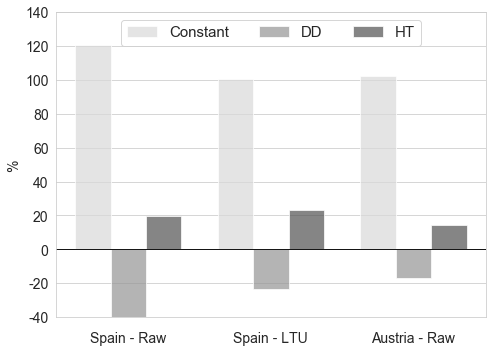

In [37]:
# sns.set_palette('GnBu',3)
sns.set_palette('Greys',3)
n_groups = 3
index = np.arange(n_groups)*1.33
bar_width = 0.33

plt.figure(figsize=(7,5))
sns.set_style('whitegrid')
plt.bar(index+ 1*bar_width,t1_plot.loc['Constant'],width=bar_width,alpha=0.7,label='Constant')
plt.bar(index+ 2*bar_width,t1_plot.loc['DD'],width=bar_width,alpha=0.7,label='DD')
plt.bar(index+ 3*bar_width,t1_plot.loc['HT'],width=bar_width,alpha=0.7,label='HT')
plt.xticks(index+0.66,['Spain - Raw','Spain - LTU','Austria - Raw'], y= -0.025,fontsize=14)
plt.axhline(lw=0.9,color='black')
plt.yticks(np.arange(-0.4,1.6,0.2),range(-40,160,20),fontsize=14)
plt.ylabel('%',fontsize=14)
plt.ylim(-0.4,1.4)
plt.grid(axis='x')
plt.legend(loc='upper center', ncol=3, frameon=True,fontsize=15)
plt.tight_layout()

# plt.savefig('g1w.png',format='png')
plt.show()

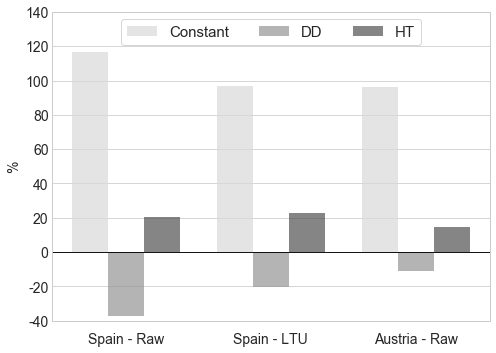

In [16]:
# sns.set_palette('GnBu',3)
sns.set_palette('Greys',3)
n_groups = 3
index = np.arange(n_groups)*1.33
bar_width = 0.33

plt.figure(figsize=(7,5))
sns.set_style('whitegrid')
plt.bar(index+ 1*bar_width,t1_plot.loc['Constant'],width=bar_width,alpha=0.7,label='Constant')
plt.bar(index+ 2*bar_width,t1_plot.loc['DD'],width=bar_width,alpha=0.7,label='DD')
plt.bar(index+ 3*bar_width,t1_plot.loc['HT'],width=bar_width,alpha=0.7,label='HT')
plt.xticks(index+0.66,['Spain - Raw','Spain - LTU','Austria - Raw'], y= -0.025,fontsize=14)
plt.axhline(lw=0.9,color='black')
plt.yticks(np.arange(-0.4,1.6,0.2),range(-40,160,20),fontsize=14)
plt.ylabel('%',fontsize=14)
plt.ylim(-0.4,1.4)
plt.grid(axis='x')
plt.legend(loc='upper center', ncol=3, frameon=True,fontsize=15)
plt.tight_layout()

# plt.savefig('g1w.png',format='png')
plt.show()

In [38]:
t2_colnames = []
t2b_colnames = []
for name in t2_plot.keys():
    if name!= 'Austria':
        t2_colnames.append('Spain - '+name)
        t2b_colnames.append(name)
    else:
        t2_colnames.append(name + ' - NE')
t2a_colnames = t2_colnames[0::3]

In [39]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

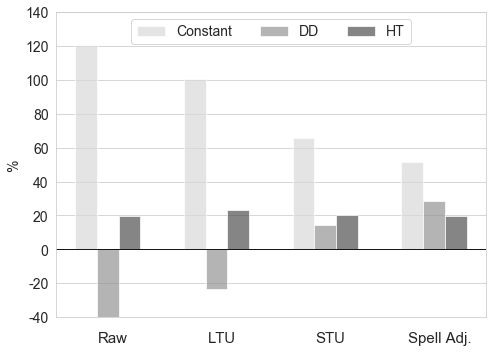

In [69]:
n_groups = 4
index = np.arange(n_groups)*1.25
bar_width = 0.25

plt.figure(figsize=(7,5))
sns.set_style('whitegrid')
sns.set_palette('Greys',3)
plt.bar(index+ 0.75*bar_width,t2d_plot.loc['Constant'],width=0.25,alpha=0.7,label='Constant')
plt.bar(index+ 1.75*bar_width,t2d_plot.loc['DD'],width=0.25,label='DD',alpha=0.7)
plt.bar(index+ 2.75*bar_width,t2d_plot.loc['HT'],width=0.25, label='HT',alpha=0.7)
plt.xticks(index+0.5,['Raw', 'LTU', 'STU', 'Spell Adj.'], y= -0.025,fontsize=15)
plt.axhline(lw=0.9,color='black')
plt.yticks(np.arange(-.4,1.6,0.2),range(-40,160,20),fontsize=14)
plt.ylim(-.4,1.4)
plt.ylabel('%',fontsize=14)
plt.grid(axis='x')
plt.legend(loc='upper center', ncol=3, frameon=True,fontsize=14)
plt.tight_layout()

plt.savefig('plots/g2.png',format='png')
plt.show()

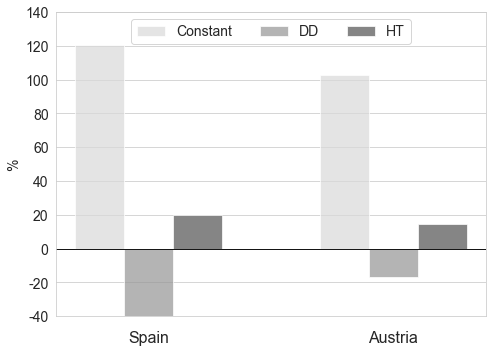

In [68]:
# sns.set_palette('GnBu',3)
sns.set_palette('Greys',3)
n_groups = 2
index = np.arange(n_groups)
bar_width = 0.2

plt.figure(figsize=(7,5))
sns.set_style('whitegrid')

# plt.subplot(121)
# plt.title('Raw data', fontsize=16, y =1.025)
plt.bar(index+ 1*bar_width,t1b_plot.loc['Constant'],width=bar_width,alpha=0.7,label='Constant')
plt.bar(index+ 2*bar_width,t1b_plot.loc['DD'],width=bar_width,label='DD',alpha=0.7) #color='darkcyan'
plt.bar(index+ 3*bar_width,t1b_plot.loc['HT'],width=bar_width, label='HT',alpha=0.7) #color='palevioletred',
plt.xticks(index+0.4,['Spain','Austria'], y= -0.025,fontsize=16)
plt.axhline(lw=0.9,color='black')
plt.yticks(np.arange(-.4,1.6,0.2),range(-40,160,20),fontsize=14)
plt.ylim(-.4,1.4)
plt.ylabel('%',fontsize=14)
plt.grid(axis='x')
plt.legend(loc='upper center', ncol=3, frameon=True,fontsize=14)
plt.tight_layout()

plt.savefig('plots/g1a.png',format='png', box_inches='tight')

plt.show()

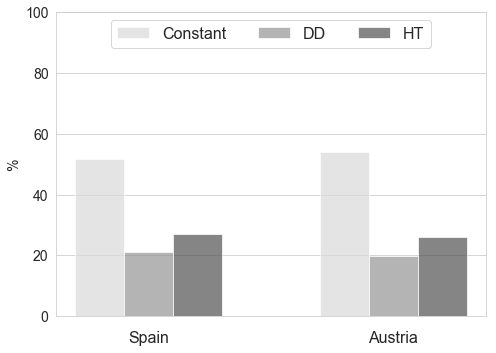

In [67]:
# sns.set_palette('GnBu',3)
sns.set_palette('Greys',3)
n_groups = 2
index = np.arange(n_groups)
bar_width = 0.2

plt.figure(figsize=(7,5))
sns.set_style('whitegrid')

# plt.title('Non-Employment', fontsize=16, y =1.025)
plt.bar(index+ 1*bar_width,t2a_plot.loc['Constant'],width=bar_width,alpha=0.7,label='Constant')
plt.bar(index+ 2*bar_width,t2a_plot.loc['DD'],width=bar_width,label='DD',alpha=0.7) #color='darkcyan'
plt.bar(index+ 3*bar_width,t2a_plot.loc['HT'],width=bar_width, label='HT',alpha=0.7) #color='palevioletred',
plt.xticks(index+0.4,['Spain','Austria'], y= -0.025,fontsize=16)
plt.axhline(lw=0.9,color='black')
plt.yticks(np.arange(0,1.2,0.2),range(0,120,20),fontsize=14)
plt.ylabel('%',fontsize=14)
plt.grid(axis='x')
plt.legend(loc='upper center', ncol=3, frameon=True,fontsize=16)
plt.tight_layout()

plt.savefig('plots/g1b.png',format='png', box_inches='tight')
plt.show()

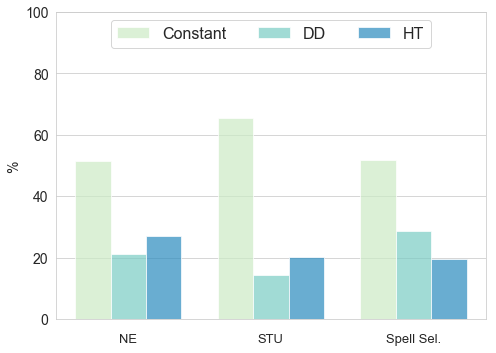

In [56]:
sns.set_palette('GnBu',3)
# sns.set_palette('Greys',3)
n_groups = 3
index = np.arange(n_groups)*1.33
bar_width = 0.33

plt.figure(figsize=(7,5))
sns.set_style('whitegrid')
plt.bar(index+ 1*bar_width,t2b_plot.loc['Constant'],width=bar_width,alpha=0.7,label='Constant')
plt.bar(index+ 2*bar_width,t2b_plot.loc['DD'],width=bar_width,label='DD',alpha=0.7) #color='darkcyan'
plt.bar(index+ 3*bar_width,t2b_plot.loc['HT'],width=bar_width, label='HT',alpha=0.7) #color='palevioletred',
plt.xticks(index+0.66,['NE','STU','Spell Sel.'], y= -0.025,fontsize=13)
plt.axhline(lw=0.9,color='black')
plt.yticks(np.arange(0,1.2,0.2),range(0,120,20),fontsize=14)
plt.ylabel('%',fontsize=14)
plt.grid(axis='x')
plt.legend(loc='upper center', ncol=3, frameon=True,fontsize=16)
plt.tight_layout()

# plt.savefig('g2b_c.png',format='png')
plt.show()

# Business Cycles

In [57]:
names = []
sigmas = []
f = open('results/table_upper07.log','r')
for line in f:
    words = line.split()    
#     print words
    if len(words)==7:
        names.append(words[0])
        sigmas.append(float(words[3]))
f.close()

CycTab = pd.DataFrame(sigmas, index=names_latex, columns=['2002-2007'])

names = []
sigmas = []
f = open('results/table_upper13.log','r')
for line in f:
    words = line.split()    
#     print words
    if len(words)==7:
        names.append(words[0])
        sigmas.append(float(words[3]))
f.close()

CycTab['2008-2013'] = sigmas

In [60]:
names = []
sigmas = []
f = open('results/table_ne07.log','r')
for line in f:
    words = line.split()    
#     print words
    if len(words)==7:
        names.append(words[0])
        sigmas.append(float(words[3]))
f.close()

CycTabNE = pd.DataFrame(sigmas, index=names_latex, columns=['2002-2007'])

names = []
sigmas = []
f = open('results/table_ne13.log','r')
for line in f:
    words = line.split()    
#     print words
    if len(words)==7:
        names.append(words[0])
        sigmas.append(float(words[3]))
f.close()

CycTabNE['2008-2013'] = sigmas

In [63]:
table_3 = CycTab.loc[table_1_index].copy()
table_3 = table_3.rename(index=dict(zip(table_1_index,index_tables)))

t3_plot = table_3.iloc[[2,4,6]].copy()
t3_plot.index=['Constant','DD','HT']

print np.round(pd.concat([table_3b, table_3], axis=1, join_axes=[table_3.index]),3).to_latex()

\begin{tabular}{lrrrr}
\toprule
{} &  2002-2007 &  2008-2013 &  2002-2007 &  2008-2013 \\
\midrule
Total    &      2.911 &      2.812 &      2.396 &      2.296 \\
Constant &      1.645 &      1.645 &      1.645 &      1.645 \\
         &      0.565 &      0.585 &      0.686 &      0.717 \\
DD       &      0.674 &      0.682 &      0.341 &      0.342 \\
         &      0.231 &      0.243 &      0.142 &      0.149 \\
HT       &      0.592 &      0.485 &      0.410 &      0.309 \\
         &      0.203 &      0.172 &      0.171 &      0.134 \\
\bottomrule
\end{tabular}



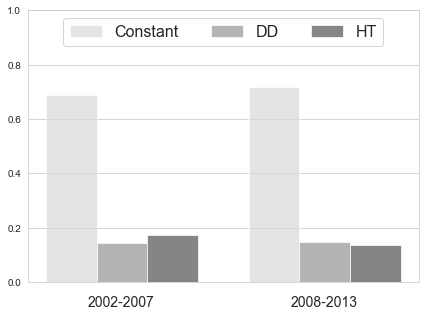

In [66]:
# sns.set_palette('GnBu',3)
sns.set_palette('Greys',3)

n_groups = 2
index = np.arange(n_groups)
bar_width = 0.25

plt.figure(figsize=(7,5))
plt.bar(index+ 0.5*bar_width,t3_plot.loc['Constant'],width=0.25,alpha=0.7,label='Constant')
plt.bar(index+ 1.5*bar_width,t3_plot.loc['DD'],width=0.25,label='DD',alpha=0.7) #color='darkcyan'
plt.bar(index+ 2.5*bar_width,t3_plot.loc['HT'],width=0.25, label='HT',alpha=0.7) #color='palevioletred',
plt.xticks(np.arange(0.37,2.37,1),t3_plot.keys(),y= -0.025,fontsize=14)
plt.axhline(lw=0.9,color='black')
plt.yticks(np.arange(0,1.2,.2))
plt.grid(axis='x')
plt.legend(loc='upper center', ncol=3, frameon=True,fontsize=16)

plt.savefig('plots/g3_stu_spell.png',format='png')
plt.show()

In [61]:
table_3b = CycTabNE.loc[table_1_index].copy()
table_3b = table_3b.rename(index=dict(zip(table_1_index,index_tables)))

t3b_plot = table_3b.iloc[[2,4,6]].copy()
t3b_plot.index=['Constant','DD','HT']

print np.round(table_3b,3).to_latex()

\begin{tabular}{lrr}
\toprule
{} &  2002-2007 &  2008-2013 \\
\midrule
Total    &      2.911 &      2.812 \\
Constant &      1.645 &      1.645 \\
         &      0.565 &      0.585 \\
DD       &      0.674 &      0.682 \\
         &      0.231 &      0.243 \\
HT       &      0.592 &      0.485 \\
         &      0.203 &      0.172 \\
\bottomrule
\end{tabular}



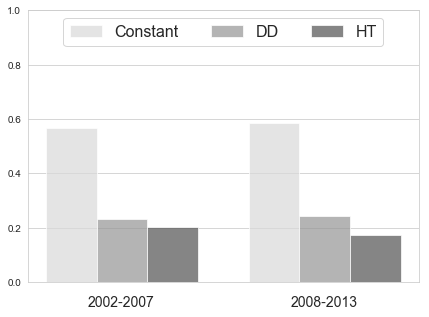

In [65]:
# sns.set_palette('GnBu',3)
sns.set_palette('Greys',3)

n_groups = 2
index = np.arange(n_groups)
bar_width = 0.25

plt.figure(figsize=(7,5))
plt.bar(index+ 0.5*bar_width,t3b_plot.loc['Constant'],width=0.25,alpha=0.7,label='Constant')
plt.bar(index+ 1.5*bar_width,t3b_plot.loc['DD'],width=0.25,label='DD',alpha=0.7) #color='darkcyan'
plt.bar(index+ 2.5*bar_width,t3b_plot.loc['HT'],width=0.25, label='HT',alpha=0.7) #color='palevioletred',
plt.xticks(np.arange(0.37,2.37,1),t3b_plot.keys(),y= -0.025,fontsize=14)
plt.axhline(lw=0.9,color='black')
plt.yticks(np.arange(0,1.2,.2))
plt.grid(axis='x')
plt.legend(loc='upper center', ncol=3, frameon=True,fontsize=16)

plt.savefig('plots/g3.png',format='png')
plt.show()